# How can we reduce the error in Zillow's Zestimate?

### Paddy Doran and Sean Oslin
November 12, 2019

# Project planning phase

### Project goals

1. Determine what factor(s) is driving the difference in Zestimate to sales price (i.e 'logerror').

2. Build an improved model to predict the logerror.

### Deliverables

1. Verbal presentation of findings
2. MySQL notebook with database queries that were imported into Python for analysis
3. README with data definitions and analysis notes
4. Data analysis in a Jupyter Notebook that will allow for replication of analysis
5. Github repository holding the analysis and supporting materials

## Acquisition, prep, and exploration

### Data source
All data originated with the Zillow database.

### Python libraries used for analysis

In [49]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import anderson
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from statsmodels.graphics.gofplots import qqplot

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


### Python programming for this analysis imported from associated text documents¶

In [50]:
import env
df = pd.read_csv("zillow.csv")

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,12177905,2288172,NaN,NaN,NaN,3,4,NaN,8.0,3,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,34245180,-118240722,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261,LCR110000*,6.037300e+07,396551.0,3101,NaN,96330.0,0,NaN,NaN,NaN,1,NaN,NaN,1970.0,NaN,NaN,108918.0,145143,2016,36225,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
1,10887214,1970746,1.0,NaN,NaN,3,3,NaN,8.0,3,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,34185120,-118414640,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266,LAR3,6.037124e+07,12447.0,3101,268548.0,96451.0,0,NaN,NaN,NaN,1,NaN,NaN,1964.0,NaN,NaN,73681.0,119407,2016,45726,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01
2,12095076,781532,1.0,NaN,NaN,3,4,NaN,9.0,3,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,34145202,-118179824,63000.0,1.0,NaN,NaN,NaN,1.0,0101,261,PSR2,6.037461e+07,47019.0,3101,274684.0,96293.0,0,NaN,NaN,NaN,1,NaN,NaN,1950.0,NaN,NaN,276684.0,773303,2016,496619,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01
3,12069064,870991,NaN,NaN,NaN,1,2,NaN,5.0,1,NaN,NaN,738.0,738.0,NaN,NaN,NaN,NaN,6037,NaN,1,NaN,NaN,NaN,NaN,34149214,-118239357,4214.0,NaN,NaN,NaN,NaN,NaN,0100,261,GLR4YY,6.037302e+07,45457.0,3101,276258.0,96325.0,0,NaN,NaN,NaN,1,NaN,NaN,1922.0,NaN,NaN,18890.0,218552,2016,199662,2366.08,NaN,NaN,6.037302e+13,0.101723,2017-01-01
4,12790562,1246926,NaN,NaN,NaN,3,4,NaN,9.0,3,NaN,NaN,3039.0,3039.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,33960230,-118006914,20028.0,NaN,NaN,NaN,NaN,NaN,0100,261,WHRE20000*,6.037500e+07,14634.0,3101,NaN,96173.0,0,NaN,NaN,NaN,1,NaN,NaN,1970.0,NaN,NaN,177527.0,220583,2016,43056,3104.19,NaN,NaN,6.037500e+13,-0.040966,2017-01-02


### Data preparation

#### Force 'head' to show all columns

In [51]:
pd.set_option('display.max_columns', None) 

#### Remove duplicate columns

In [52]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [53]:
df = remove_dup_col(df)

#### Calculate the number and percent of missing values for each attribute

In [54]:
def df2(df):
    num_rows_missing = df.isna().sum()
    pct_rows_missing = num_rows_missing/len(df)*100
    df_sum = pd.DataFrame()
    df_sum['num_rows_missing'] = num_rows_missing
    df_sum['pct_rows_missing'] = pct_rows_missing
    return df_sum
# df2(df)

#### Delete rows and columns with excessing missing values

In [56]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [57]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

#### Drop unneeded columns

In [58]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [59]:
df = drop_col(df)

### Manage missing values

For land square feet, impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x-variable and the output/y-variable is the estimated land square feet.

#### Use linear model to calculate predicted values for 'lotsizesquarefeet'.

In [60]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

#### If value is NaN, replace with the predicted ('yhat') value. Otherwise, keep y value.

In [61]:
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

#### Impute other missing values from the median value

In [62]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

#### Use linear model to calculate predicted values for 'taxamount'

In [63]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

#### If value is NaN, replace with the predicted ('yhat') value. Otherwise, keep y value.¶

In [64]:
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

### Drop rows with no 'yearbuilt' date

In [65]:
df.fillna(value=pd.np.nan, inplace=True)

In [66]:
df = df.dropna()

In [67]:
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

In [68]:
df = drop_col2(df)

### Adjust data types

In [69]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']].astype('int64')

### Manage outliers

#### Upper outliers

While the most common value for k is 1.5, we experimented with values as high as 5 because of the very high number of outliers. We settled on 4 to eliminate many of the outliers, but not too drastically reduce the rows of data. 

In [70]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [71]:
new_df = add_upper_outlier_columns(df, k = 4.0)
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())
    new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]
    new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
    new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0) & (new_df.landtaxvaluedollarcnt_outliers == 0)]
    


~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

#### Lower outliers

The number of lower outliers was quite small. We decided not to exclude them from the analysis.

In [72]:
def get_lower_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1- k * iqr
    return s.apply(lambda x: x if x < lower_bound else 0)

def add_lower_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_lower_outliers(df[col], k)
                     for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_lower_outliers(df3[col], k)

    return df

add_lower_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000


#### Drop outlier columns

In [73]:
def drop_col(new_df):
    new_df = new_df.drop(columns = [
           'parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
           'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
           'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
           'heatingorsystemtypeid_outliers', 'latitude_outliers',
           'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
           'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
           'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
           'logerror_outliers', 'propertyzoningdesc', 'buildingqualitytypeid', 'heatingorsystemtypeid'])
    return new_df

In [74]:
new_df = drop_col(new_df)

### Split data into train and test for data exploration.

In [75]:
train, test = train_test_split(new_df, test_size=.30, random_state = 123)

### Data encoding

#### Encode the bathroom and bedroom counts into separate variables for each size

In [76]:
def one_hot_encode(train, test, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)

    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                            columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [77]:
train, test = one_hot_encode(train, test, col_name = 'bathroomcnt')

#### Rename encoded colums. 

In [78]:
train.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
test.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)

#### Rename encoded colums.

In [79]:
train, test = one_hot_encode(train, test, col_name = 'bedroomcnt')

In [80]:
train.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
test.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)

In [81]:
train.reset_index(drop = True, inplace = True)
test.reset_index(inplace = True)

### Data scaling
Because of the nature of the scaling we considered both MinMax and Standard scalers. We settled on Standard as it is the most frequently used. Additionally, we chose to scale only the variables that with units of dollars and square feet.

In [82]:
scaler = StandardScaler()

train_scaled = train.copy()
test_scaled = test.copy()

train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
scaler.fit(train_scaled)
scaler.fit(test_scaled)
train_scaled = scaler.transform(train_scaled)
test_scaled = scaler.transform(test_scaled)                   

In [83]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [127]:
train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]= train_scaled[['calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]

#### Create dependent variable 'logerror'

In [86]:
# X_train = train.drop(columns ='logerror')
# y_train = train[['logerror']]
# X_test = test.drop(columns ='logerror')
# y_test = test[['logerror']]

In [87]:
# X_train.info()

## Cluster analysis

### Create first set of clusters: count of bedrooms and bathrooms

   k           sse
0  1  43738.037848
1  2  22164.072712
2  3  16033.746843
3  4  12201.645569
4  5   8935.899676
5  6   7520.628117
6  7   5566.666269
7  8   3949.735016
8  9   3116.453341


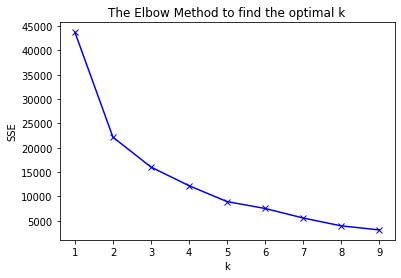

In [88]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [89]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])
    train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt']])
    return train

In [90]:
train1 = target_cluster(train)

In [91]:
train1.groupby(train1['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.192178e+07,1.486349e+06,1.452668,1.871749,-0.787652,6037.0,3.404596e+07,-1.182663e+08,-0.416132,1.0,1954.828206,0.200921,-0.240442,-0.115111,-0.007449,0.547332,0.452668,0.000000,0.000000,0.000000,0.000000,0.000000,0.128251,0.871749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.193019e+07,1.510208e+06,1.760787,3.000000,-0.325371,6037.0,3.410836e+07,-1.182135e+08,-0.384202,1.0,1955.734382,-0.303744,-0.260024,-0.156408,-0.002196,0.239213,0.760787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,1.184355e+07,1.523575e+06,3.062315,2.740851,0.341889,6037.0,3.412194e+07,-1.182895e+08,0.562969,1.0,1980.397873,0.458387,0.383912,0.233007,0.001472,0.000000,0.000000,0.940653,0.056627,0.002473,0.000247,0.000000,0.002226,0.254698,0.743076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.193899e+07,1.524584e+06,1.951876,4.075407,0.104814,6037.0,3.413543e+07,-1.182076e+08,-0.237973,1.0,1958.074649,-0.309989,-0.213652,-0.166203,0.001522,0.048124,0.951876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.933687,0.057977,0.007579,0.000758,0.000000,0.000000
3,1.182873e+07,1.487807e+06,3.348642,4.327727,1.465493,6037.0,3.418304e+07,-1.182886e+08,1.016166,1.0,1976.718197,-0.014876,0.586677,0.280480,0.010332,0.000000,0.000000,0.732859,0.195558,0.062743,0.007762,0.001078,0.000000,0.000000,0.000000,0.721216,0.238465,0.033204,0.005821,0.001078,0.000216


#### Number of observations per cluster

In [92]:
train1.cluster.value_counts()

1    8900
2    6729
3    4638
0    4044
4    2639
Name: cluster, dtype: int64

In [93]:
train1.groupby('cluster').mean()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.184355e+07,1.523575e+06,3.062315,2.740851,0.341889,6037.0,3.412194e+07,-1.182895e+08,0.562969,1.0,1980.397873,0.458387,0.383912,0.233007,0.001472,0.000000,0.000000,0.940653,0.056627,0.002473,0.000247,0.000000,0.002226,0.254698,0.743076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.193019e+07,1.510208e+06,1.760787,3.000000,-0.325371,6037.0,3.410836e+07,-1.182135e+08,-0.384202,1.0,1955.734382,-0.303744,-0.260024,-0.156408,-0.002196,0.239213,0.760787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.192178e+07,1.486349e+06,1.452668,1.871749,-0.787652,6037.0,3.404596e+07,-1.182663e+08,-0.416132,1.0,1954.828206,0.200921,-0.240442,-0.115111,-0.007449,0.547332,0.452668,0.000000,0.000000,0.000000,0.000000,0.000000,0.128251,0.871749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.182873e+07,1.487807e+06,3.348642,4.327727,1.465493,6037.0,3.418304e+07,-1.182886e+08,1.016166,1.0,1976.718197,-0.014876,0.586677,0.280480,0.010332,0.000000,0.000000,0.732859,0.195558,0.062743,0.007762,0.001078,0.000000,0.000000,0.000000,0.721216,0.238465,0.033204,0.005821,0.001078,0.000216
4,1.193899e+07,1.524584e+06,1.951876,4.075407,0.104814,6037.0,3.413543e+07,-1.182076e+08,-0.237973,1.0,1958.074649,-0.309989,-0.213652,-0.166203,0.001522,0.048124,0.951876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.933687,0.057977,0.007579,0.000758,0.000000,0.000000


#### Check of validity of the clusters and X and Y variables by mapping the clusters against themselves. This pattern appears as expected. 

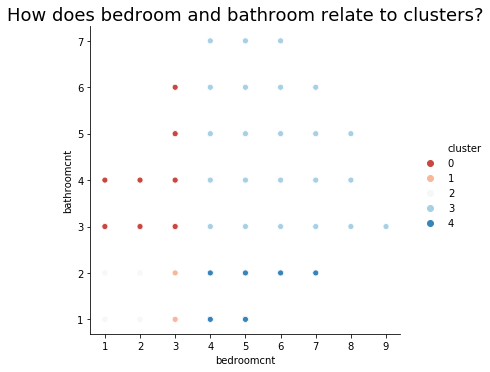

In [94]:
sns.relplot(data=train1, x='bedroomcnt', y='bathroomcnt', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does bedroom and bathroom relate to clusters?', fontsize = 18)
plt.show()

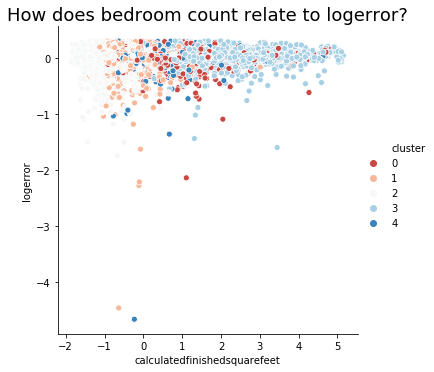

In [95]:
sns.relplot(data=train1, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does finshed square feet relate to logerror?', fontsize = 18)
plt.show()

#### Using bedroom and bathroom counts as clusters, the graph above may indicate significant groups when looking at the finished square feet and logerror.

#### We can test the if the means are different using a one-way ANOVA test. First, we must determine if the the clusters are normally distributed. 

#### Create clusters to test for normality.

In [98]:
cluster_0 =train1[train1.cluster == 0]
cluster_1 =train1[train1.cluster == 1]
cluster_2 =train1[train1.cluster == 2]
cluster_3 =train1[train1.cluster == 3]
#cluster_4 =train1[train1.cluster == 4] Cluster 4 will not work. Unsure of error. 

#### Plot clusters using histograms to visually check if distributions are normal.  All seem to follow a Gaussian distribution. 

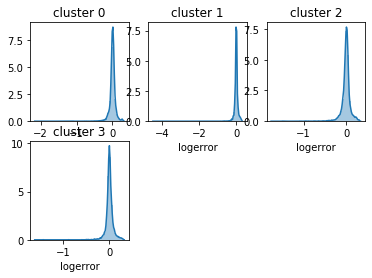

In [99]:
plt.title('Check for normality for 5 logerror clusters')

plt.subplot(231)
sns.distplot(cluster_0.logerror)
plt.title('cluster 0')

plt.subplot(232)
sns.distplot(cluster_1.logerror)
plt.title('cluster 1')

plt.subplot(233)
sns.distplot(cluster_2.logerror)
plt.title('cluster 2')

plt.subplot(234)
sns.distplot(cluster_3.logerror)
plt.title('cluster 3')

# plt.subplot(235)
# sns.distplot(cluster_4.logerror)
# plt.title('cluster 4')

plt.show()

#### Plot clusters using a Q-Q plot to visually check if distributions are normal. All clusters have questionable Gaussian distribution.

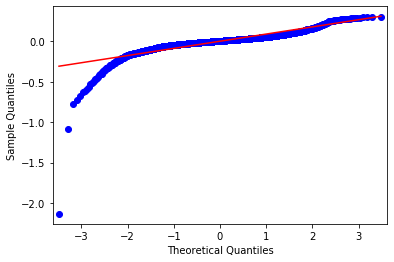

In [104]:
qqplot(cluster_0.logerror, line='s')
plt.show()

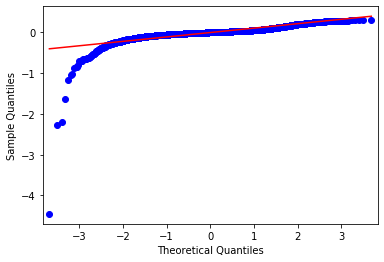

In [105]:
qqplot(cluster_1.logerror, line='s')
plt.show()

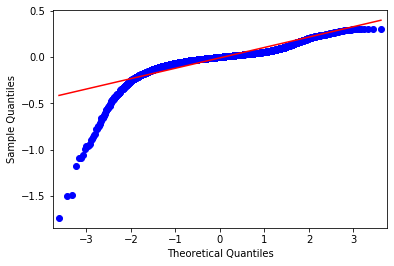

In [106]:
qqplot(cluster_2.logerror, line='s')
plt.show()

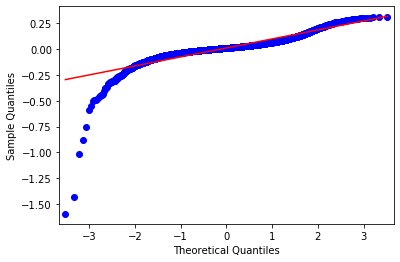

In [107]:
qqplot(cluster_3.logerror, line='s')
plt.show()

#### Run 2 parametric tests (Anderson-Darling and Shapiro-Wilks) to check if distributions are normal.

None of the clusters appear to be normally distributed. (Only tests for cluster_0 are shown below.)

Conclusion: normality cannot be assumed using parametric tests. The one-way ANOVA test cannot be run to test the means of the clusters against each other. 

In [112]:
result = anderson(cluster_0.logerror)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))


Statistic: 188.464
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


In [118]:
stat, p = shapiro(cluster_0.logerror)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian')
else:
	print('Sample does not look Gaussian')

Statistics=0.742, p=0.000
Sample does not look Gaussian


#### Using bedroom and bathroom counts as clusters, none of the X and Y pairings below demonstrated any visually significant relationships. 

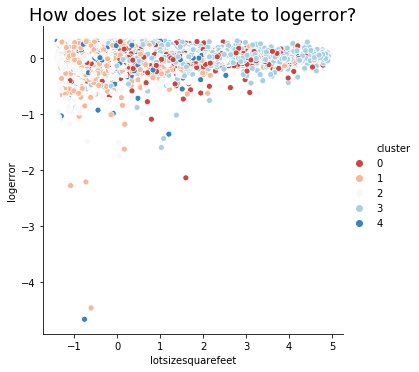

In [120]:
sns.relplot(data=train1, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

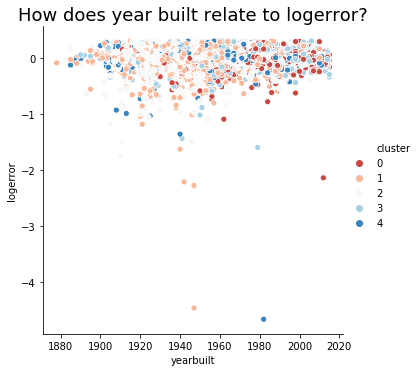

In [121]:
sns.relplot(data=train1, x='yearbuilt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does year built relate to logerror?', fontsize = 18)
plt.show()

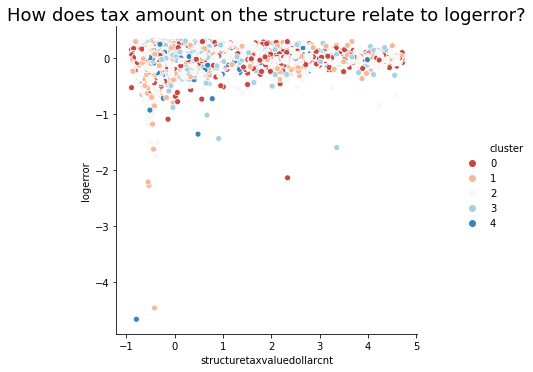

In [122]:
sns.relplot(data=train1, x='structuretaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does tax amount on the structure relate to logerror?', fontsize = 18)
plt.show()

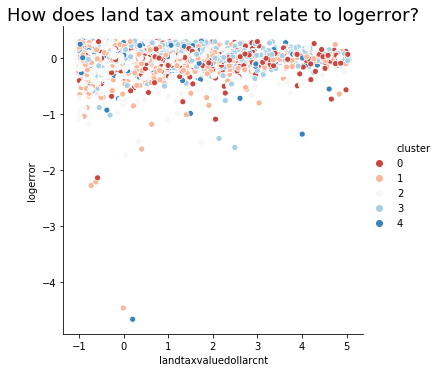

In [128]:
sns.relplot(data=train1, x='landtaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does land tax amount relate to logerror?', fontsize = 18)
plt.show()

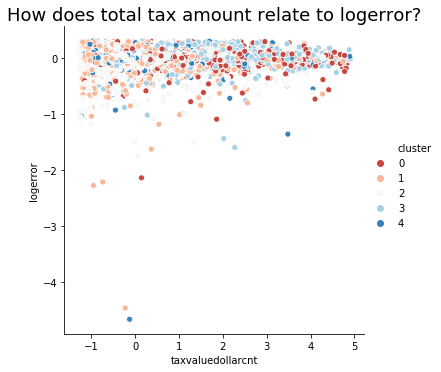

In [124]:
sns.relplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does total tax amount relate to logerror?', fontsize = 18)
plt.show()

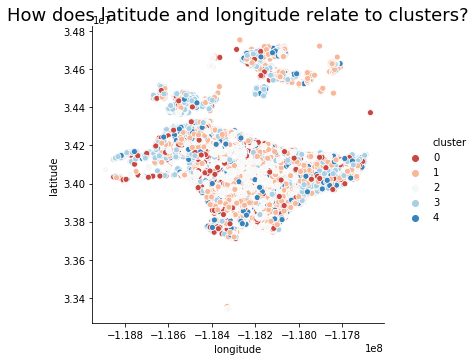

In [125]:
sns.relplot(data=train1, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does latitude and longitude relate to clusters?', fontsize = 18)
plt.show()

### Create second set of clusters: latitude and longitude

No apparent patterns were seen in the clusters

   k           sse
0  1  2.638030e+15
1  2  1.532507e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363503e+14
5  6  3.547538e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093329e+14


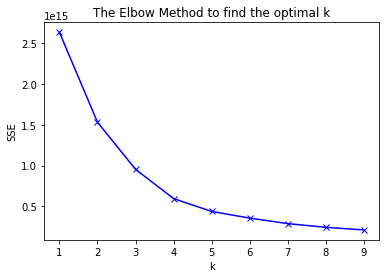

In [129]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['latitude', 'longitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [130]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(train[['latitude', 'longitude']])
    train['cluster'] = kmeans.predict(train[['latitude', 'longitude']])
    return train

In [131]:
train2 = target_cluster(train)

In [132]:
train2.groupby(train2['cluster']).mean().sort_values('taxvaluedollarcnt')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.132419e+07,1.508189e+06,2.367110,3.462860,0.293553,6037.0,3.462946e+07,-1.181250e+08,-0.100432,1.0,1986.195792,-0.066187,-0.675232,-0.841315,-0.002267,0.068699,0.536711,0.357664,0.032632,0.004294,0.000000,0.000000,0.003864,0.049377,0.519536,0.349506,0.063976,0.012452,0.001288,0.000000,0.000000
2,1.263879e+07,1.514806e+06,2.130714,3.102181,-0.033156,6037.0,3.406801e+07,-1.179848e+08,-0.106048,1.0,1960.494921,-0.062090,-0.115709,-0.101084,0.004753,0.222289,0.478040,0.257245,0.032566,0.008963,0.000747,0.000149,0.016283,0.210786,0.485958,0.237974,0.041380,0.005826,0.001643,0.000149,0.000000
1,1.222645e+07,1.505133e+06,1.915872,2.821364,-0.257002,6037.0,3.389409e+07,-1.182546e+08,-0.217584,1.0,1955.620398,-0.146093,-0.085402,-0.007045,-0.004301,0.347858,0.429572,0.186602,0.031141,0.004587,0.000121,0.000121,0.044176,0.324683,0.437296,0.159565,0.029089,0.004345,0.000604,0.000241,0.000000
0,1.124145e+07,1.493979e+06,2.371189,3.007675,0.199934,6037.0,3.420010e+07,-1.184616e+08,0.299579,1.0,1965.615432,0.144731,0.293746,0.241897,-0.000279,0.146132,0.448040,0.321717,0.060568,0.020017,0.003215,0.000311,0.040241,0.277951,0.396080,0.215723,0.061398,0.007260,0.001037,0.000207,0.000104


#### Number of observations per cluster

In [133]:
train2.cluster.value_counts()

0    9642
1    8285
2    6694
3    2329
Name: cluster, dtype: int64

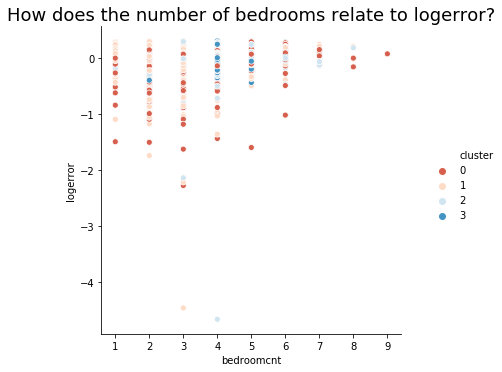

In [134]:
sns.relplot(data=train2, x='bedroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does the number of bedrooms relate to logerror?', fontsize = 18)
plt.show()

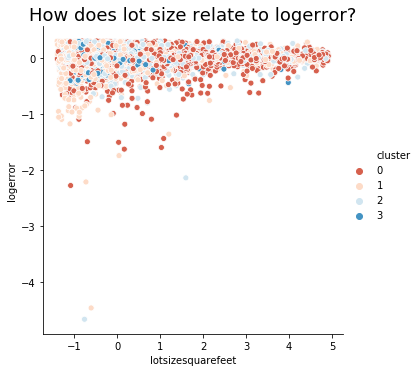

In [135]:
sns.relplot(data=train2, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

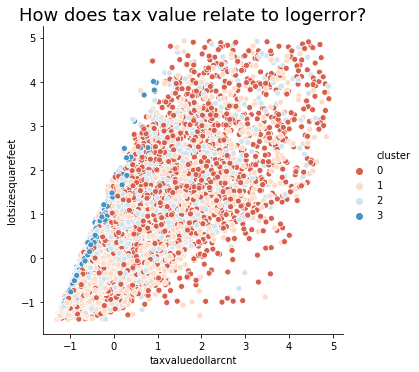

In [136]:
sns.relplot(data=train2, x='taxvaluedollarcnt', y='lotsizesquarefeet', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does tax value relate to logerror?', fontsize = 18)
plt.show()

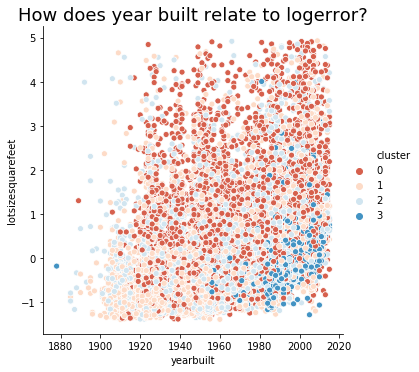

In [160]:
sns.relplot(data=train2, x='yearbuilt', y='lotsizesquarefeet', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does year built relate to lot size?', fontsize = 18)
plt.show()

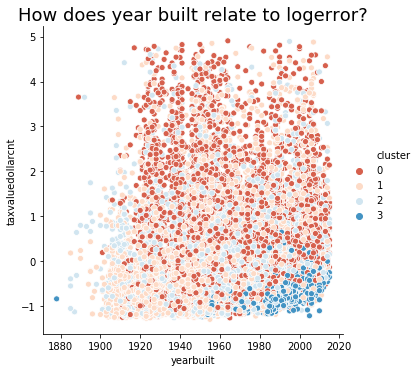

In [161]:
sns.relplot(data=train2, x='yearbuilt', y='taxvaluedollarcnt', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does year built relate to tax value?', fontsize = 18)
plt.show()

### Histograms of all variables

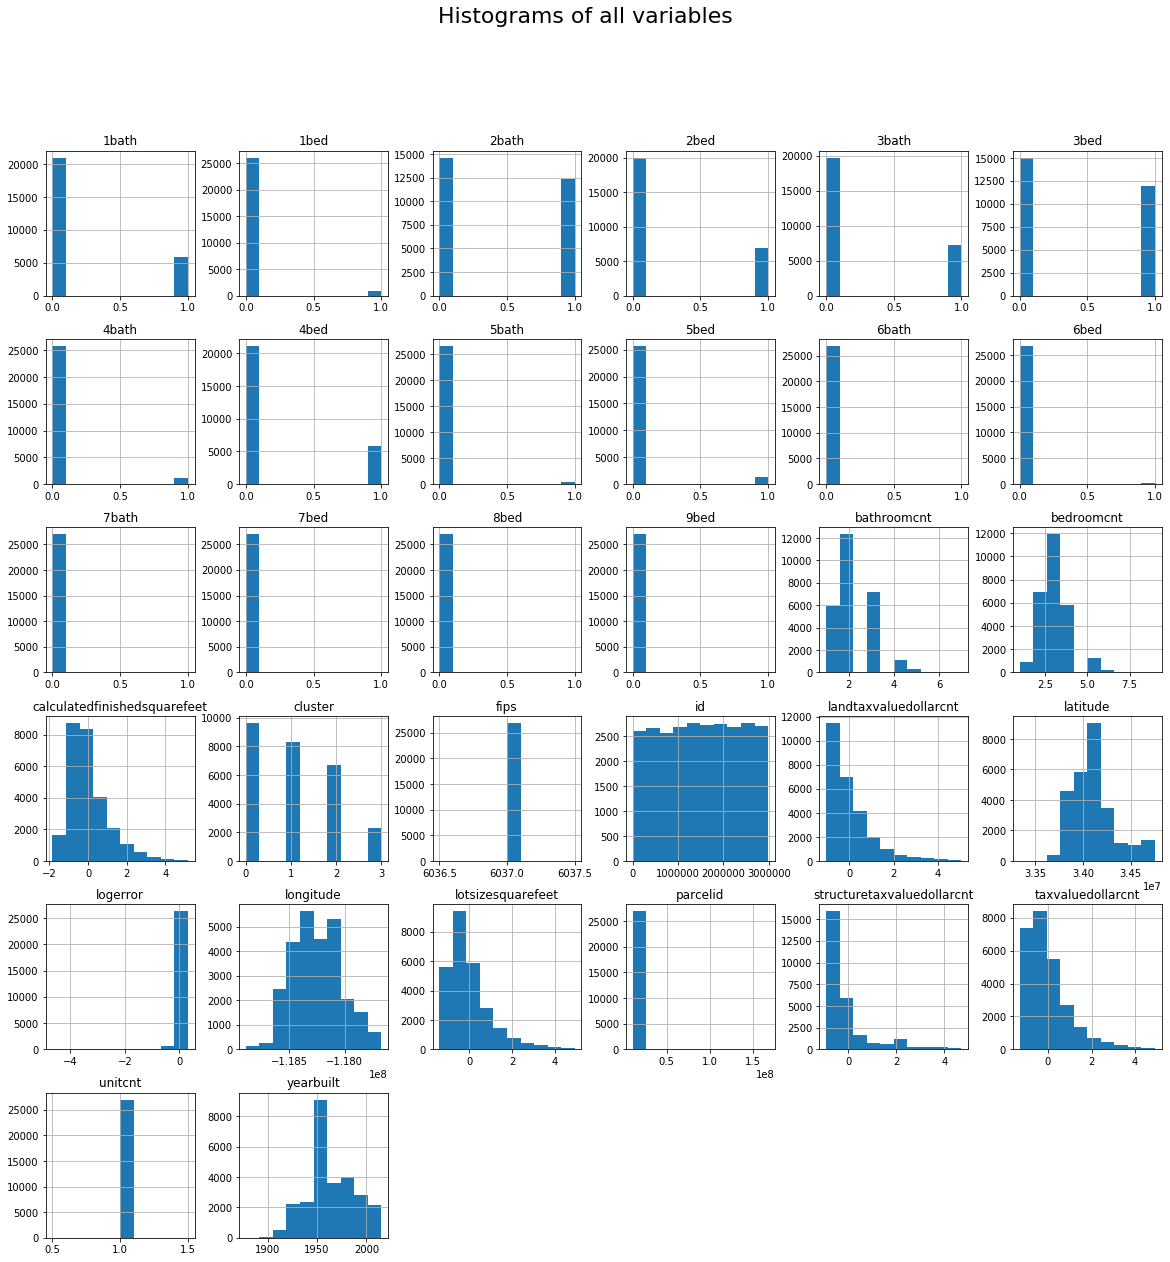

In [162]:
train.hist(figsize=(20, 20), bins=10, log=False)
plt.suptitle('Histograms of all variables', fontsize = 22)
plt.show()

### Jointplots (scatter plot and histograms) of select variables do not show any obvous relationships.

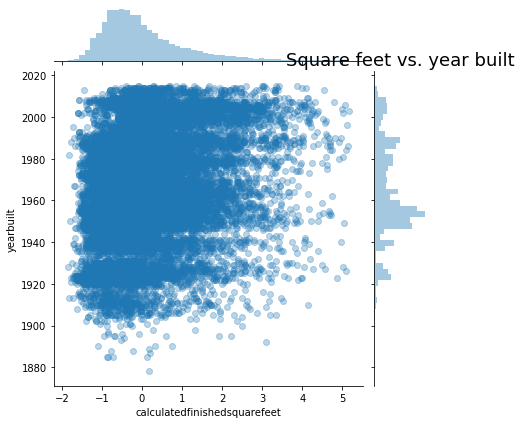

In [164]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='yearbuilt', alpha = .3)
plt.title('Square feet vs. year built', fontsize = 18)
plt.show()

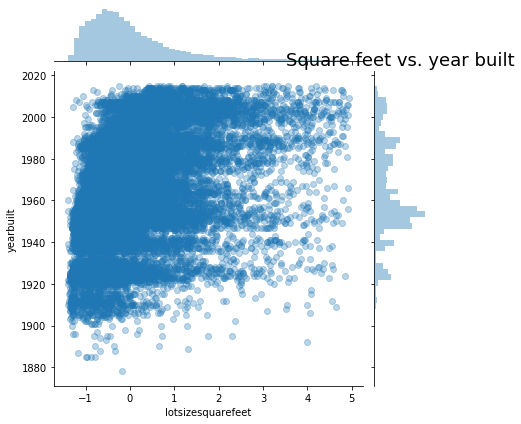

In [167]:
sns.jointplot(data=train, x='lotsizesquarefeet', y='yearbuilt', alpha = .3)
plt.title('Square feet vs. year built', fontsize = 18)
plt.show()

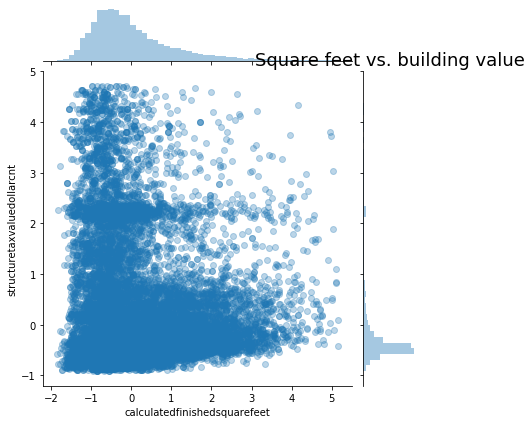

In [166]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='structuretaxvaluedollarcnt', alpha = .3)
plt.title('Square feet vs. building value', fontsize = 18)
plt.show()

## Correlation matrix/heatmap of all variables

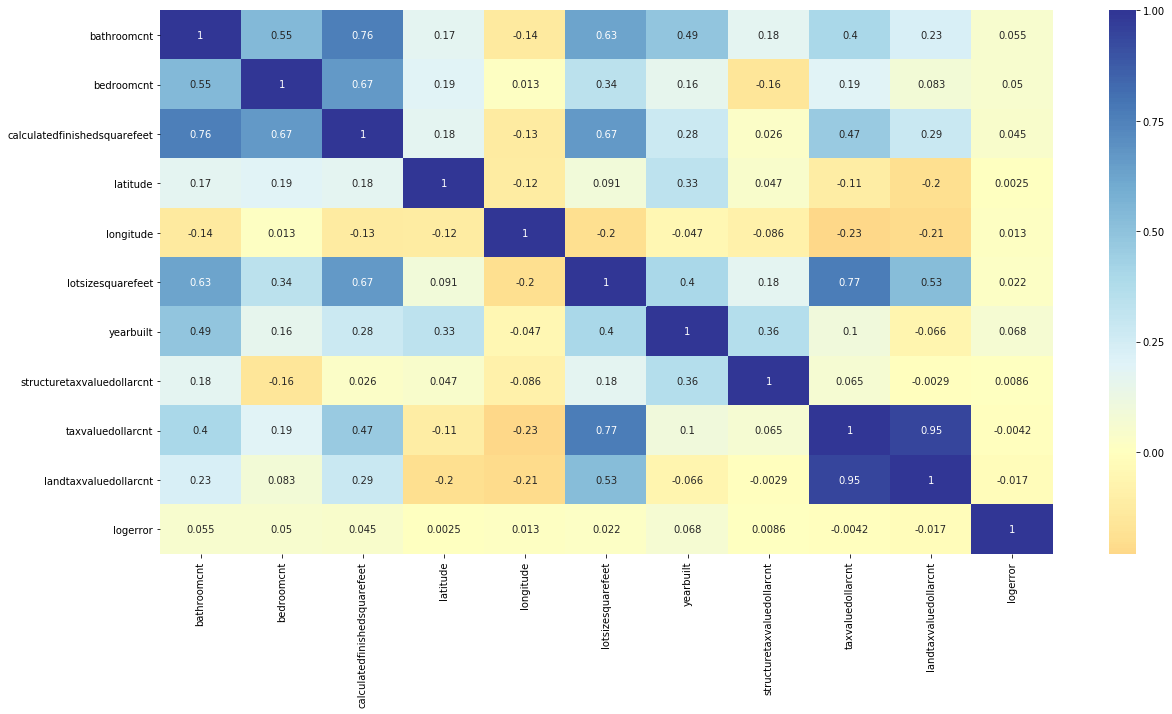

In [139]:
corr1 = train[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','latitude', 'longitude', 'lotsizesquarefeet','yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror']]
plt.figure(figsize=(20,10))
sns.heatmap(corr1.corr(), cmap='RdYlBu', annot=True, center=0)
plt.show()

### T-tests

#### T-test 1

H<sub>0</sub> : The logerror for single-unit properties with 1 bathroom is the same as properties with 2 bathrooms

H<sub>a</sub> : The logerror for single-unit properties with 1 bathroom is NOT the same as properties with 2 bathrooms

In [181]:
one_bathroom = train[train['bathroomcnt']==1.0]
three_bathroom = train[train['bathroomcnt']==2.0]
stats.ttest_ind(one_bathroom['logerror'], three_bathroom['logerror'])

Ttest_indResult(statistic=-5.039038427519528, pvalue=4.7234278177180693e-07)

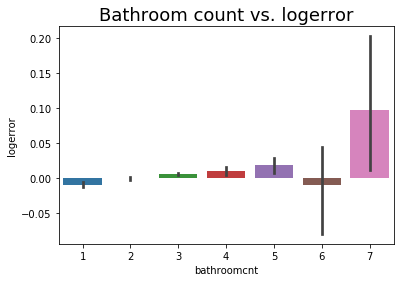

In [183]:
plt.title('Bathroom count vs. logerror', fontsize = 18)
sns.barplot(x=X_train["bathroomcnt"], y=y_train["logerror"])
plt.show()

#### Reject H<sub>0</sub>. The logerror for single-unit properties with 1 bathroom is NOT the same as properties with 2 bathrooms.

More generalized, the logerror is statistically different for all bathroom counts except 6.

#### T-test 2

H<sub>0</sub> : The logerror for single-unit properties with 1 bedroom is the same as properties with 3 bedrooms

H<sub>a</sub> : The logerror for single-unit properties with 1 bedroom is NOT the same as properties with 3 bedrooms

In [188]:
one_bedroom = train[train['bedroomcnt']==1.0]
three_bedroom = train[train['bedroomcnt']==5.0]
stats.ttest_ind(one_bedroom['logerror'], three_bedroom['logerror'])

Ttest_indResult(statistic=-3.9223366722762774, pvalue=9.04721047973656e-05)

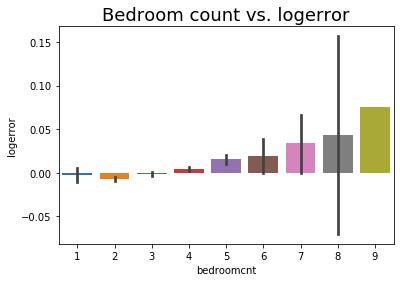

In [184]:
plt.title('Bedroom count vs. logerror', fontsize = 18)
sns.barplot(x=X_train["bedroomcnt"], y=y_train["logerror"])
plt.show()

#### Fail to reject H<sub>0</sub>.  The logerror for single-unit properties with 1 bedroom is the same as properties with 2 bedrooms.

More generalized, the logerror is statistically different for for all single-unit residences with 5 or more bedrooms.

In [140]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'logerror', '1bath', '2bath', '3bath', '4bath',
       '5bath', '6bath', '7bath', '1bed', '2bed', '3bed', '4bed', '5bed',
       '6bed', '7bed', '8bed', '9bed', 'cluster'],
      dtype='object')

In [141]:
from sklearn.cluster import KMeans

C1 = train[['latitude', 'longitude', 'lotsizesquarefeet']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(C1)

print(kmeans.cluster_centers_)



[[ 3.38939061e+07 -1.18254533e+08 -2.17394478e-01]
 [ 3.40679771e+07 -1.17984697e+08 -1.06048160e-01]
 [ 3.46294603e+07 -1.18124955e+08 -1.00432174e-01]
 [ 3.41999722e+07 -1.18461388e+08  2.98819577e-01]]


In [142]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C1.columns)
centers
C1Label = pd.Series(kmeans.labels_)
C1Label.value_counts()

3    9638
0    8292
1    6691
2    2329
dtype: int64

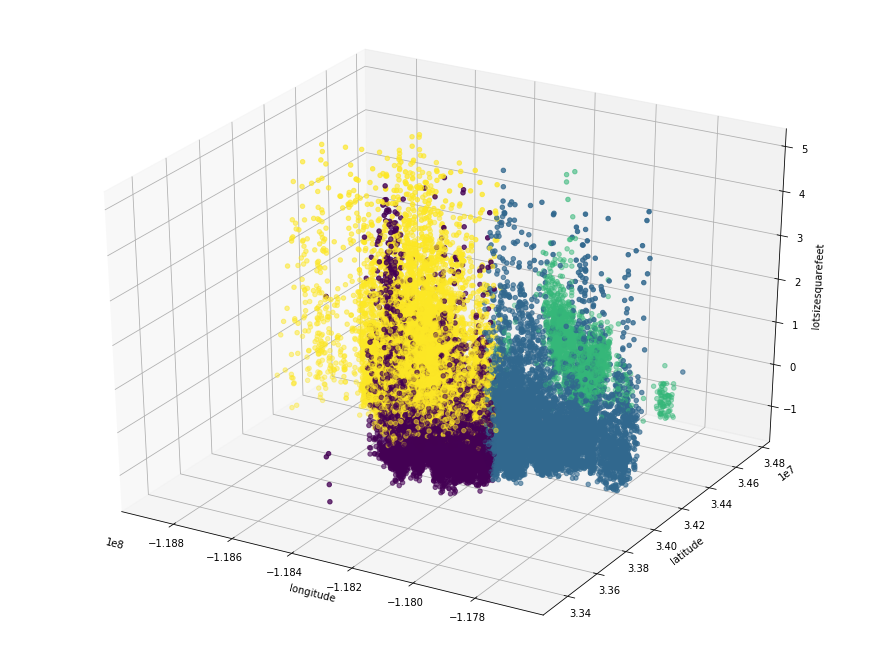

In [143]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C1.longitude, C1.latitude, C1.lotsizesquarefeet, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.lotsizesquarefeet, c='pink', s=100, alpha=.9)
ax.set(xlabel='longitude', ylabel='latitude', zlabel='lotsizesquarefeet')
plt.show()

In [144]:
C2 = train[['latitude', 'longitude', 'structuretaxvaluedollarcnt']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(C2)
centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=C2.columns)
print(centers2)
C2Label = pd.Series(kmeans.labels_)
C2Label.value_counts()
print(kmeans.cluster_centers_)

       latitude     longitude  structuretaxvaluedollarcnt
0  3.389419e+07 -1.182550e+08                   -0.145954
1  3.420025e+07 -1.184619e+08                    0.144902
2  3.462946e+07 -1.181250e+08                   -0.066187
3  3.406789e+07 -1.179852e+08                   -0.062082
[[ 3.38941920e+07 -1.18254954e+08 -1.45953598e-01]
 [ 3.42002469e+07 -1.18461859e+08  1.44901606e-01]
 [ 3.46294603e+07 -1.18124955e+08 -6.61872956e-02]
 [ 3.40678910e+07 -1.17985217e+08 -6.20818546e-02]]


In [145]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C2.columns)
centers
C2Label = pd.Series(kmeans.labels_)
C2Label.value_counts()

1    9622
0    8302
3    6697
2    2329
dtype: int64

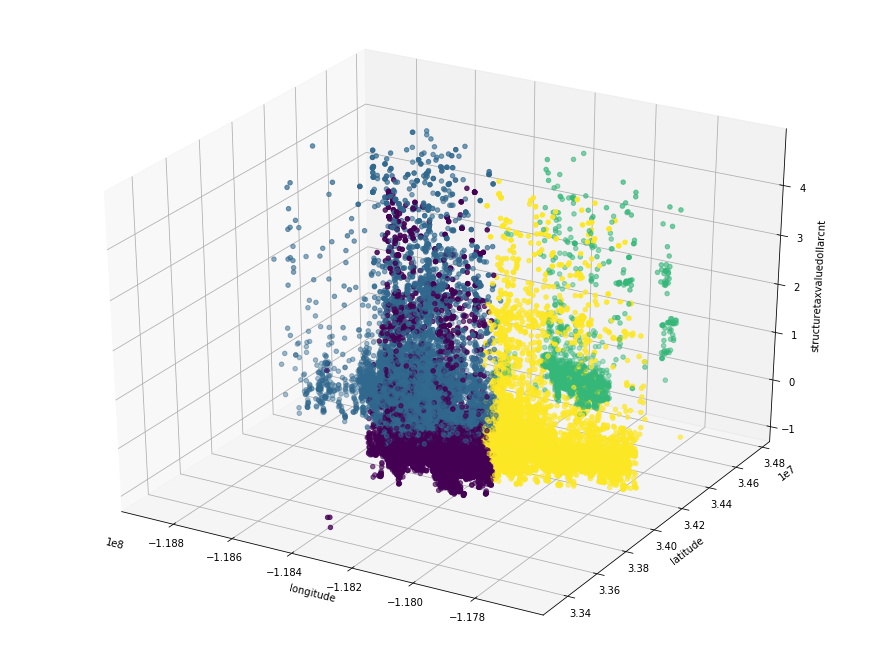

In [146]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C2.longitude, C2.latitude, C2.structuretaxvaluedollarcnt, c=kmeans.labels_)
# ax.scatter(centers.longitude, centers.latitude, centers.structuretaxvaluedollarcnt, c='pink', s=100, alpha=.9)
ax.set(xlabel='longitude', ylabel='latitude', zlabel='structuretaxvaluedollarcnt')
plt.show()

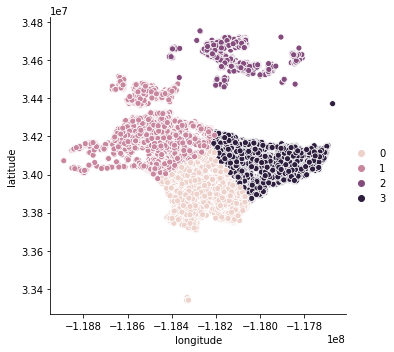

In [147]:
sns.relplot(data=C2, hue=kmeans.labels_, x='longitude', y='latitude')
plt.show()

   k           sse
0  1  2.638030e+15
1  2  1.532504e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363497e+14
5  6  3.547522e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093192e+14


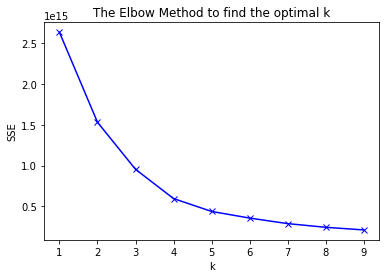

In [148]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['longitude', 'latitude', 'calculatedfinishedsquarefeet']])
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))
plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()



In [149]:
C3 = train[['latitude', 'longitude', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(C3)
centers3 = pd.DataFrame(kmeans.cluster_centers_, columns=C3.columns)
print(centers3)
C3Label = pd.Series(kmeans.labels_)
C3Label.value_counts()
print(kmeans.cluster_centers_)

       latitude     longitude  calculatedfinishedsquarefeet
0  3.420022e+07 -1.184617e+08                      0.200179
1  3.406785e+07 -1.179850e+08                     -0.033451
2  3.389420e+07 -1.182549e+08                     -0.256820
3  3.462946e+07 -1.181250e+08                      0.293553
[[ 3.42002244e+07 -1.18461740e+08  2.00179241e-01]
 [ 3.40678458e+07 -1.17985038e+08 -3.34510904e-02]
 [ 3.38941958e+07 -1.18254918e+08 -2.56819983e-01]
 [ 3.46294603e+07 -1.18124955e+08  2.93553334e-01]]


In [150]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C3.columns)
centers
C3Label = pd.Series(kmeans.labels_)
C3Label.value_counts()

0    9625
2    8299
1    6697
3    2329
dtype: int64

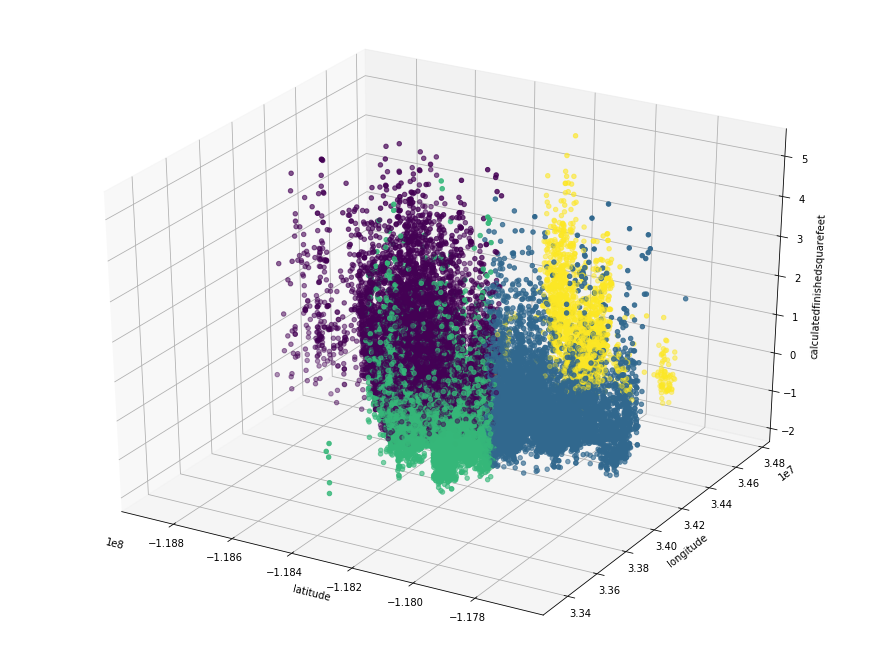

In [151]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C3.longitude, C3.latitude, C3.calculatedfinishedsquarefeet, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.calculatedfinishedsquarefeet, c='pink', s=100, alpha=.9)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='calculatedfinishedsquarefeet')
plt.show()

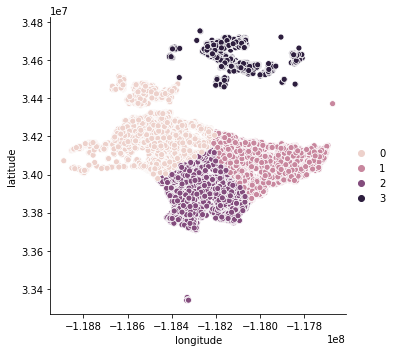

In [152]:
sns.relplot(data=C3, hue=kmeans.labels_, x='longitude', y='latitude')

In [153]:
def target_cluster(cluster_df):
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(cluster_df)
    cluster_df['cluster_df'] = kmeans.predict(cluster_df)
    new_train = train.merge(cluster_df,left_index=True,right_index=True)
    return new_train

In [154]:
ntrain = target_cluster(C1)
ntrain

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude_x,longitude_x,lotsizesquarefeet_x,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster,latitude_y,longitude_y,lotsizesquarefeet_y,cluster_df
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,34165692,-118770919,2.727203,1
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33784829,-118314531,-0.838683,2
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,34042958,-118142629,-0.272130,2
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,34685575,-118177612,-0.378959,0
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33983552,-118118690,-1.011569,2
5,12780879,2767461,1,2,-1.001686,6037,33995428,-118061989,-0.690118,1,1949,-0.535035,-0.372301,-0.156038,-0.161329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33995428,-118061989,-0.690118,2
6,12074832,2854200,2,2,-0.588026,6037,34188239,-118221986,-1.027935,1,1964,-0.594970,-1.044281,-0.877939,0.052668,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34188239,-118221986,-1.027935,1
7,12593082,947718,2,3,-0.683926,6037,33841700,-118288241,-0.934452,1,1961,-0.580890,-0.452658,-0.143460,0.030410,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33841700,-118288241,-0.934452,2
8,12110890,423917,1,2,-1.280799,6037,34141000,-118134000,-0.540801,1,1986,0.961375,0.031110,0.303282,0.013285,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,34141000,-118134000,-0.540801,2
9,11276014,1076857,3,4,0.050356,6037,34711965,-118164839,-0.117314,1,1993,-0.403288,-0.715212,-0.885825,-0.007703,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,34711965,-118164839,-0.117314,0


In [155]:
def target_cluster(cluster_df):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(cluster_df)
    cluster_df['cluster_df2'] = kmeans.predict(cluster_df)
    new_train = ntrain.merge(cluster_df,left_index=True,right_index=True)
    return new_train

In [156]:
target_cluster(C2)

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude_x,longitude_x,lotsizesquarefeet_x,unitcnt,yearbuilt,structuretaxvaluedollarcnt_x,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster,latitude_y,longitude_y,lotsizesquarefeet_y,cluster_df,latitude,longitude,structuretaxvaluedollarcnt_y,cluster_df2
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,34165692,-118770919,2.727203,1,34165692,-118770919,-0.214909,1
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33784829,-118314531,-0.838683,2,33784829,-118314531,-0.183526,2
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,34042958,-118142629,-0.272130,2,34042958,-118142629,-0.457953,3
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,34685575,-118177612,-0.378959,0,34685575,-118177612,-0.205549,0
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33983552,-118118690,-1.011569,2,33983552,-118118690,-0.356803,3
5,12780879,2767461,1,2,-1.001686,6037,33995428,-118061989,-0.690118,1,1949,-0.535035,-0.372301,-0.156038,-0.161329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,33995428,-118061989,-0.690118,2,33995428,-118061989,-0.535035,3
6,12074832,2854200,2,2,-0.588026,6037,34188239,-118221986,-1.027935,1,1964,-0.594970,-1.044281,-0.877939,0.052668,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34188239,-118221986,-1.027935,1,34188239,-118221986,-0.594970,1
7,12593082,947718,2,3,-0.683926,6037,33841700,-118288241,-0.934452,1,1961,-0.580890,-0.452658,-0.143460,0.030410,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33841700,-118288241,-0.934452,2,33841700,-118288241,-0.580890,2
8,12110890,423917,1,2,-1.280799,6037,34141000,-118134000,-0.540801,1,1986,0.961375,0.031110,0.303282,0.013285,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,34141000,-118134000,-0.540801,2,34141000,-118134000,0.961375,3
9,11276014,1076857,3,4,0.050356,6037,34711965,-118164839,-0.117314,1,1993,-0.403288,-0.715212,-0.885825,-0.007703,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,34711965,-118164839,-0.117314,0,34711965,-118164839,-0.403288,0


In [189]:
ef target_cluster(lst):
    for i,ele in enumerate(lst):
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(ele)
        ele['cluster_df'+str(i)] = kmeans.predict(ele)
        global train 
        train = train.merge(ele['cluster_df'+str(i)],left_index=True,right_index=True)
    return train

SyntaxError: invalid syntax (<ipython-input-189-013cd232ad4d>, line 1)

In [190]:
# print(C1.head())
# print(C2.head())
# print(C3.head())

In [191]:
target_cluster([C1,C2,C3])

ValueError: setting an array element with a sequence.

In [157]:
X_train = train.drop(columns ='logerror')
y_train = train[['logerror']]
X_test = test.drop(columns ='logerror')
y_test = test[['logerror']]

In [158]:
# train.drop(columns = (['bathroomcnt', 'bedroomcnt']))
# test.drop(columns = (['bathroomcnt', 'bedroomcnt']))

In [159]:
predictions=pd.DataFrame({'actual':y_train['logerror']}).reset_index(drop=True)
predictions['baseline'] = y_train.mean()[0]
predictions.head()

,actual,baseline
0,-0.061629,-0.000437
1,0.015970,-0.000437
2,-0.133100,-0.000437
3,-0.043454,-0.000437
4,0.016932,-0.000437
